<a href="https://colab.research.google.com/github/Kuzay3t/Wells_classification/blob/main/SPE_datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary libaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# uploading necessary files

from google.colab import files
file = files.upload()

Saving classification_parameters.csv to classification_parameters.csv
Saving Innovisors_DSEATS_Africa_2025_Classification.csv to Innovisors_DSEATS_Africa_2025_Classification.csv
Saving reservoir_info.csv to reservoir_info.csv
Saving spe_africa_dseats_datathon_2025_wells_dataset.csv to spe_africa_dseats_datathon_2025_wells_dataset.csv


In [ ]:
# reading the csv files

wells_df = pd.read_csv("spe_africa_dseats_datathon_2025_wells_dataset.csv")
reservoir_df = pd.read_csv("reservoir_info.csv")
classification_df = pd.read_csv("classification_parameters.csv")

In [ ]:
# cleaning the well data set
print("This shows the summary of missing values in each column in the well dataset")
print("=======================================================")
print((wells_df.isnull().sum()))
print("=======================================================")

This shows the summary of missing values in each column in the well dataset
PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_PRESS (PSI)                     0
CHOKE_SIZE (%)                          0
WELL_HEAD_PRESSURE (PSI)                0
WELL_HEAD_TEMPERATURE (deg F)           0
CUMULATIVE_OIL_PROD (STB)               0
CUMULATIVE_FORMATION_GAS_PROD (MSCF)    0
CUMULATIVE_TOTAL_GAS_PROD (MSCF)        0
CUMULATIVE_WATER_PROD (BBL)             0
dtype: int64


In [ ]:
# EDA of the Well Datset
print("=======================================================")
print("This shows the first 10 rows in the well dataset")
print(wells_df.head(10))
print("=======================================================")


print("=======================================================")
print("This shows the statistical summary of the well dataset")
print(wells_df.describe())
print("=======================================================")

print("=======================================================")
print("This shows column information the well dataset")
print(wells_df.info())
print("=======================================================")

This shows the first 10 rows in the well dataset
   PROD_DATE WELL_NAME  ON_STREAM_HRS BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0  15-Feb-14   Well_#1            0.0                             4,050   
1  16-Feb-14   Well_#1            0.0                             3,961   
2  17-Feb-14   Well_#1            0.0                             3,961   
3  18-Feb-14   Well_#1            0.0                             3,964   
4  19-Feb-14   Well_#1            0.0                             3,965   
5  20-Feb-14   Well_#1            0.0                             3,964   
6  21-Feb-14   Well_#1            0.0                             3,972   
7  22-Feb-14   Well_#1            0.0                             3,978   
8  23-Feb-14   Well_#1            0.0                             3,985   
9  24-Feb-14   Well_#1            0.0                             4,096   

   DOWNHOLE_TEMPERATURE (deg F) ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                   0   

# **Determining Saturation or Unsaturation of each resorvoir**

In [ ]:
# Clean numeric columns (remove commas and convert to float)
reservoir_df["Initial Reservoir Pressure (PSI)"] = reservoir_df["Initial Reservoir Pressure (PSI)"].str.replace(",", "").astype(float)
reservoir_df["Bubble Point Pressure (PSI)"] = reservoir_df["Bubble Point Pressure (PSI)"].str.replace(",", "").astype(float)


In [ ]:
print("Converted 'Initial Reservoir Pressure (PSI)' values:")
print(reservoir_df["Initial Reservoir Pressure (PSI)"])

Converted 'Initial Reservoir Pressure (PSI)' values:
0    3500.0
1    4200.0
2    3500.0
3    2800.0
4    4500.0
Name: Initial Reservoir Pressure (PSI), dtype: float64


In [ ]:
# Classify saturation status
reservoir_df["Saturation Status"] = reservoir_df.apply(
    lambda row: "Saturated" if row["Initial Reservoir Pressure (PSI)"] == row["Bubble Point Pressure (PSI)"]
               else ("Undersaturated" if row["Initial Reservoir Pressure (PSI)"] > row["Bubble Point Pressure (PSI)"]
               else "Invalid (Check Data)"),
    axis=1
)

In [ ]:
# Add calculation explanation
reservoir_df["Calculation"] = reservoir_df.apply(
    lambda row: f"Initial Pressure ({row['Initial Reservoir Pressure (PSI)']} PSI) {'=' if row['Saturation Status'] == 'Saturated' else '>'} Bubble Point ({row['Bubble Point Pressure (PSI)']} PSI)",
    axis=1
)

In [ ]:
# Print results
print(reservoir_df[["Reservoir Name", "Saturation Status", "Calculation"]])

  Reservoir Name Saturation Status  \
0           ACHI    Undersaturated   
1           KEMA    Undersaturated   
2           MAKO         Saturated   
3           DEPU         Saturated   
4           JANI    Undersaturated   

                                         Calculation  
0  Initial Pressure (3500.0 PSI) > Bubble Point (...  
1  Initial Pressure (4200.0 PSI) > Bubble Point (...  
2  Initial Pressure (3500.0 PSI) = Bubble Point (...  
3  Initial Pressure (2800.0 PSI) = Bubble Point (...  
4  Initial Pressure (4500.0 PSI) > Bubble Point (...  


## **Finding whether the Reservoir is Steady or Unsteady**

In [ ]:
# Convert date and ensure proper sorting
wells_df["PROD_DATE"] = pd.to_datetime(wells_df["PROD_DATE"], format="%d-%b-%y")
wells_df = wells_df.sort_values(["WELL_NAME", "PROD_DATE"])

# Clean the cumulative production column: remove commas and convert to numeric
wells_df["CUMULATIVE_OIL_PROD (STB)"] = wells_df["CUMULATIVE_OIL_PROD (STB)"].str.replace(",", "").astype(float)


# Calculate daily oil production (difference between cumulative values)
wells_df["Daily_Oil_Prod (STB)"] = wells_df.groupby("WELL_NAME")["CUMULATIVE_OIL_PROD (STB)"].diff().fillna(0)

# Handle negative values (if any)
wells_df["Daily_Oil_Prod (STB)"] = wells_df["Daily_Oil_Prod (STB)"].clip(lower=0)

# Print the final calculated daily production for each well
print("=== Final Daily Oil Production (STB) ===")
print(wells_df[["WELL_NAME", "PROD_DATE", "Daily_Oil_Prod (STB)"]].tail(20))

=== Final Daily Oil Production (STB) ===
     WELL_NAME  PROD_DATE  Daily_Oil_Prod (STB)
3529   Well_#9 2016-07-24                 140.0
3530   Well_#9 2016-07-25                 134.0
3531   Well_#9 2016-07-26                 129.0
3532   Well_#9 2016-07-27                 127.0
3533   Well_#9 2016-07-28                 129.0
3534   Well_#9 2016-07-29                 130.0
3535   Well_#9 2016-07-30                 132.0
3536   Well_#9 2016-07-31                 132.0
3537   Well_#9 2016-08-01                 137.0
3538   Well_#9 2016-08-02                 129.0
3539   Well_#9 2016-08-03                 124.0
3540   Well_#9 2016-08-04                 118.0
3541   Well_#9 2016-08-05                 122.0
3542   Well_#9 2016-08-06                 119.0
3543   Well_#9 2016-08-07                 120.0
3544   Well_#9 2016-08-08                 119.0
3545   Well_#9 2016-08-09                 111.0
3546   Well_#9 2016-08-10                 118.0
3547   Well_#9 2016-08-11                 121.0

## **Task 1: Identify the Reservoir for Each Well**
For each well, find the maximum bottomhole flowing pressure (BHP) from its 30 days of data.
Then, assign the well to a reservoir whose current average pressure is within ±200 psi of that max BHP.



In [ ]:
# Group by well and find the max BHP for each
max_bhp_df = wells_df.groupby('WELL_NAME')["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"].max().reset_index()
max_bhp_df.columns = ['WELL_NAME', 'MAX_BHP']


In [ ]:
# Clean pressure data (remove commas and convert to float)
wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"] = (
    wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"]
    .str.replace(",", "")
    .astype(float)
)


In [ ]:
reservoir_df["Current Average Reservoir Pressure (PSI)"] = (
    reservoir_df["Current Average Reservoir Pressure (PSI)"]
    .str.replace(",", "")
    .astype(float)
)


In [ ]:
# Step 1: Find max BHFP for each well
max_bhfp = wells_df.groupby("WELL_NAME")["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"].max().reset_index()

# Step 2: Function to assign reservoir based on 200 PSI rule
def assign_reservoir(bhfp):
    for _, row in reservoir_df.iterrows():
        reservoir_name = row["Reservoir Name"]
        reservoir_pressure = row["Current Average Reservoir Pressure (PSI)"]
        if abs(bhfp - reservoir_pressure) <= 200:
            return reservoir_name
    return "Unknown"  # If no reservoir matches

In [ ]:
# Step 3: Assign reservoirs to wells
max_bhfp["Reservoir"] = max_bhfp["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"].apply(assign_reservoir)

# Display results
print(max_bhfp[["WELL_NAME", "Reservoir", "BOTTOMHOLE_FLOWING_PRESSURE (PSI)"]])

   WELL_NAME Reservoir  BOTTOMHOLE_FLOWING_PRESSURE (PSI)
0    Well_#1      KEMA                             4096.0
1   Well_#10      KEMA                             4051.0
2   Well_#11      ACHI                             2521.0
3   Well_#12      ACHI                             2557.0
4   Well_#13      DEPU                             2246.0
5   Well_#14      ACHI                             2857.0
6   Well_#15      KEMA                             4032.0
7   Well_#16      KEMA                             3836.0
8   Well_#17      DEPU                             2304.0
9   Well_#18      ACHI                             2621.0
10  Well_#19      KEMA                             4036.0
11   Well_#2      KEMA                             3735.0
12  Well_#20      ACHI                             2858.0
13   Well_#3      MAKO                             2985.0
14   Well_#4      DEPU                             2340.0
15   Well_#5      MAKO                             2933.0
16   Well_#6  

## **WELL EXPLORATORY DATA ANALYSIS**

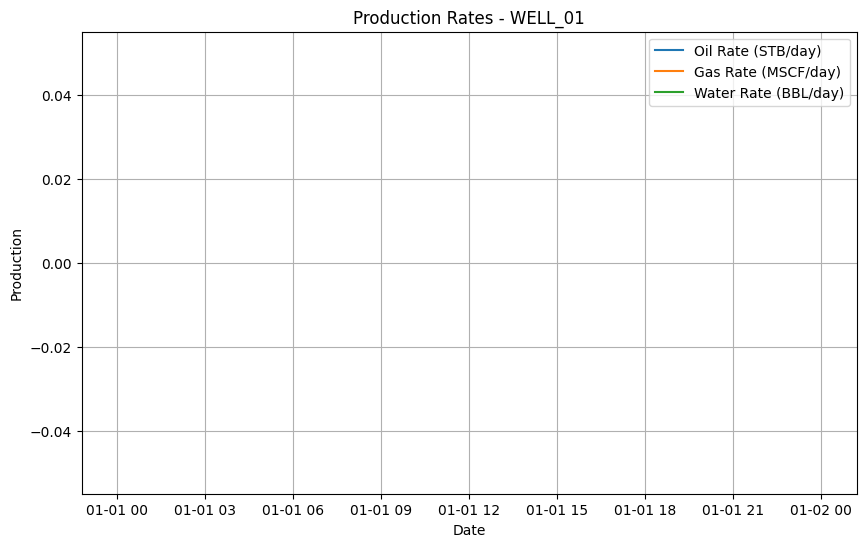

In [ ]:
import matplotlib.pyplot as plt

# Choose a well to visualize
well_name = "WELL_01"

# Filter data for just that well
well_data = wells_df[wells_df["WELL_NAME"] == well_name]

# Sort by production date
well_data["PROD_DATE"] = pd.to_datetime(well_data["PROD_DATE"])
well_data = well_data.sort_values("PROD_DATE")

# Compute daily rates
well_data['dOil'] = well_data['CUMULATIVE_OIL_PROD (STB)'].diff()
well_data['dWater'] = well_data['CUMULATIVE_WATER_PROD (BBL)'].diff()
well_data['dGas'] = well_data['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff()
well_data['GOR'] = well_data['dGas'] / well_data['dOil']
well_data['Watercut'] = well_data['dWater'] / (well_data['dOil'] + well_data['dWater'])

# Plot 1: Oil, Gas, Water Rates
plt.figure(figsize=(10, 6))
plt.plot(well_data["PROD_DATE"], well_data["dOil"], label="Oil Rate (STB/day)")
plt.plot(well_data["PROD_DATE"], well_data["dGas"], label="Gas Rate (MSCF/day)")
plt.plot(well_data["PROD_DATE"], well_data["dWater"], label="Water Rate (BBL/day)")
plt.title(f"Production Rates - {well_name}")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.grid(True)
plt.show()

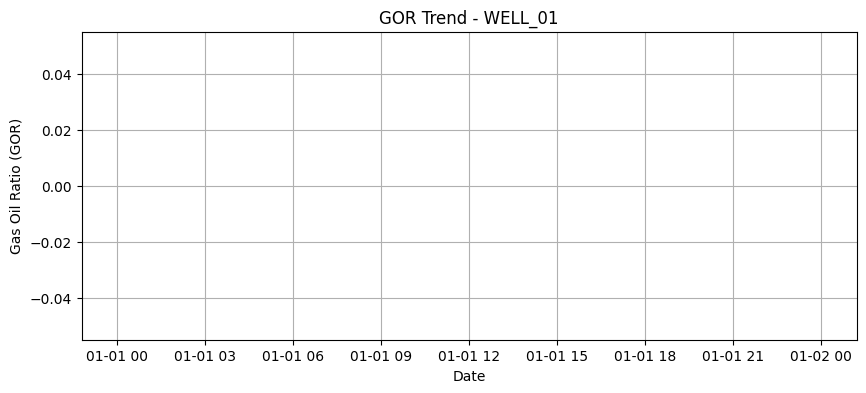

In [ ]:
# Plot 2: GOR
plt.figure(figsize=(10, 4))
plt.plot(well_data["PROD_DATE"], well_data["GOR"], color='purple')
plt.title(f"GOR Trend - {well_name}")
plt.xlabel("Date")
plt.ylabel("Gas Oil Ratio (GOR)")
plt.grid(True)
plt.show()

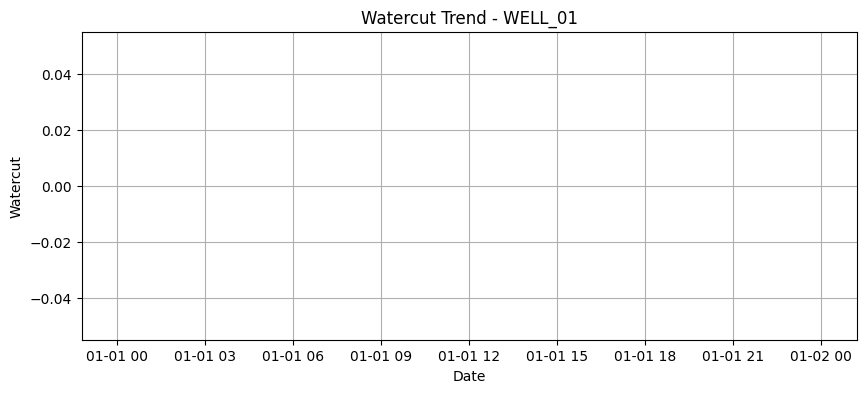

In [ ]:

# Plot 3: Watercut
plt.figure(figsize=(10, 4))
plt.plot(well_data["PROD_DATE"], well_data["Watercut"], color='blue')
plt.title(f"Watercut Trend - {well_name}")
plt.xlabel("Date")
plt.ylabel("Watercut")
plt.grid(True)
plt.show()


## **Determine Oil Productivity Index (PI) Trend**

In [ ]:
# Clean pressure data (remove commas)
wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"] = wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"].astype(float)
reservoir_df["Current Average Reservoir Pressure (PSI)"] = reservoir_df["Current Average Reservoir Pressure (PSI)"].astype(float)

In [ ]:
# Merge reservoir information (including the assigned reservoir) into wells data
wells_df = wells_df.merge(
    max_bhfp[["WELL_NAME", "Reservoir"]],
    on="WELL_NAME",
    how="left"
)

# Merge reservoir pressure into wells data using the newly merged 'Reservoir' column
wells_df = wells_df.merge(
    reservoir_df[["Reservoir Name", "Current Average Reservoir Pressure (PSI)"]],
    left_on="Reservoir",
    right_on="Reservoir Name",
    how="left"
)

# Drop the redundant 'Reservoir Name' column
wells_df = wells_df.drop("Reservoir Name", axis=1)

# Display the updated wells_df with merged information
print(wells_df.head())

   PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F) ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                   0         1.17951   
1                       189.945                   0         2.99440   
2                       190.004                   0         1.90349   
3                       190.020                   0         0.00000   
4                       190.107                   0        30.20760   

  WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.46                         50.8

In [ ]:
# Calculate daily oil production (STB/day)
wells_df["Daily_Oil_Prod (STB)"] = wells_df.groupby("WELL_NAME")["CUMULATIVE_OIL_PROD (STB)"].diff().fillna(0)

# Calculate pressure drawdown and PI
wells_df["Drawdown (PSI)"] = wells_df["Current Average Reservoir Pressure (PSI)"] - wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"]
wells_df["PI (STB/day/PSI)"] = wells_df["Daily_Oil_Prod (STB)"] / wells_df["Drawdown (PSI)"]

# Handle infinite/negative values (e.g., zero drawdown)
wells_df["PI (STB/day/PSI)"] = wells_df["PI (STB/day/PSI)"].replace([float('inf'), -float('inf')], 0).clip(lower=0)

In [ ]:
from scipy.stats import linregress

def classify_pi_trend(pi_series):
    x = np.arange(len(pi_series))  # Time steps
    slope, _, _, _, _ = linregress(x, pi_series)

    if abs(slope) < 0.1 * pi_series.mean():  # Flat (slope near zero)
        return "Flat"
    elif slope > 0:                          # Increasing
        return "Increasing"
    elif slope < 0:                          # Decreasing
        return "Decreasing"
    else:                                    # Mixed trends
        return "Combination"

# Group by well and classify trends
pi_trends = wells_df.groupby("WELL_NAME")["PI (STB/day/PSI)"].apply(
    lambda x: classify_pi_trend(x.dropna())  # Drop NaN values
).reset_index(name="PI_Trend")

print(pi_trends)

   WELL_NAME     PI_Trend
0    Well_#1         Flat
1   Well_#10  Combination
2   Well_#11         Flat
3   Well_#12         Flat
4   Well_#13         Flat
5   Well_#14         Flat
6   Well_#15         Flat
7   Well_#16         Flat
8   Well_#17         Flat
9   Well_#18         Flat
10  Well_#19         Flat
11   Well_#2         Flat
12  Well_#20         Flat
13   Well_#3         Flat
14   Well_#4         Flat
15   Well_#5         Flat
16   Well_#6         Flat
17   Well_#7         Flat
18   Well_#8         Flat
19   Well_#9         Flat


## **Determine Watercut Trend**

In [ ]:
# Clean cumulative production columns (remove commas and convert to numeric)
wells_df["CUMULATIVE_WATER_PROD (BBL)"] = wells_df["CUMULATIVE_WATER_PROD (BBL)"].astype(str).str.replace(",", "").astype(float)
wells_df["CUMULATIVE_OIL_PROD (STB)"] = wells_df["CUMULATIVE_OIL_PROD (STB)"].astype(str).str.replace(",", "").astype(float)

# Calculate daily water and oil production
wells_df["Daily_Water_Prod (BBL)"] = wells_df.groupby("WELL_NAME")["CUMULATIVE_WATER_PROD (BBL)"].diff().fillna(0)
wells_df["Daily_Oil_Prod (STB)"] = wells_df.groupby("WELL_NAME")["CUMULATIVE_OIL_PROD (STB)"].diff().fillna(0)

# Convert oil to BBL (assuming 1 STB = 1 BBL for simplicity; adjust if needed)
wells_df["Daily_Oil_Prod (BBL)"] = wells_df["Daily_Oil_Prod (STB)"]

# Calculate watercut (%)
wells_df["Watercut"] = wells_df["Daily_Water_Prod (BBL)"] / (wells_df["Daily_Oil_Prod (BBL)"] + wells_df["Daily_Water_Prod (BBL)"])
wells_df["Watercut"] = wells_df["Watercut"].fillna(0)

In [ ]:
def classify_watercut_trend(watercut_series):
    if len(watercut_series) < 2:
        return "Insufficient Data"

    x = np.arange(len(watercut_series))
    slope, _, _, _, _ = linregress(x, watercut_series)

    if abs(slope) < 0.005:  # Flat (slope near zero)
        return "Flat"
    elif slope > 0:          # Increasing
        return "Increasing"
    elif slope < 0:          # Decreasing
        return "Decreasing"
    else:                    # Mixed trends
        return "Combination"

# Group by well and classify trends
watercut_trends = wells_df.groupby("WELL_NAME")["Watercut"].apply(
    lambda x: classify_watercut_trend(x.dropna())
).reset_index(name="Watercut_Trend")

print(watercut_trends)

   WELL_NAME Watercut_Trend
0    Well_#1           Flat
1   Well_#10           Flat
2   Well_#11           Flat
3   Well_#12           Flat
4   Well_#13           Flat
5   Well_#14           Flat
6   Well_#15           Flat
7   Well_#16           Flat
8   Well_#17           Flat
9   Well_#18           Flat
10  Well_#19           Flat
11   Well_#2           Flat
12  Well_#20           Flat
13   Well_#3           Flat
14   Well_#4           Flat
15   Well_#5           Flat
16   Well_#6           Flat
17   Well_#7           Flat
18   Well_#8           Flat
19   Well_#9           Flat


## **Calculate Total Reservoir Barrels of Oil Produced per Reservoir**

In [ ]:
# Clean and merge data
wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"] = wells_df["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"].astype(float)
reservoir_df["Formation Volume Factor (RB/STB)"] = reservoir_df["Formation Volume Factor (RB/STB)"].astype(float)

In [ ]:
# Merge reservoir FVF into wells data
wells_df = wells_df.merge(
    reservoir_df[["Reservoir Name", "Formation Volume Factor (RB/STB)"]],
    left_on="Reservoir",  # Column from your reservoir assignment step
    right_on="Reservoir Name",
    how="left"
)

In [ ]:
# Calculate reservoir barrels for each well's last record (total cumulative production)
total_reservoir_barrels = wells_df.groupby(["Reservoir", "WELL_NAME"])["CUMULATIVE_OIL_PROD (STB)"].last().reset_index()

# Merge with wells_df to get the Formation Volume Factor for each well
total_reservoir_barrels = total_reservoir_barrels.merge(
    wells_df[["WELL_NAME", "Formation Volume Factor (RB/STB)"]].drop_duplicates(subset=['WELL_NAME']),
    on="WELL_NAME",
    how="left"
)

total_reservoir_barrels["Reservoir_Barrels"] = (
    total_reservoir_barrels["CUMULATIVE_OIL_PROD (STB)"] *
    total_reservoir_barrels["Formation Volume Factor (RB/STB)"]
)

# Sum reservoir barrels by reservoir
reservoir_totals = total_reservoir_barrels.groupby("Reservoir")["Reservoir_Barrels"].sum().reset_index()
print(reservoir_totals)

  Reservoir  Reservoir_Barrels
0      ACHI         2268804.00
1      DEPU         1513123.90
2      KEMA         1723802.05
3      MAKO          374285.90


## **Determine Well Type (Naturally Flowing vs. Gas Lifted)**

In [ ]:
# Clean annulus pressure data (remove commas, convert to float)
wells_df["ANNULUS_PRESS (PSI)"] = (
    wells_df["ANNULUS_PRESS (PSI)"]
    .str.replace(",", "")
    .astype(float)
    .fillna(0)  # Treat missing values as 0
)

# Classify well type based on annulus pressure
wells_df["Well_Type"] = wells_df["ANNULUS_PRESS (PSI)"].apply(
    lambda x: "GL" if x > 0 else "NF"
)

# Summarize results
well_type_summary = wells_df.groupby("WELL_NAME")["Well_Type"].first().reset_index()
print(well_type_summary)

   WELL_NAME Well_Type
0    Well_#1        NF
1   Well_#10        GL
2   Well_#11        GL
3   Well_#12        NF
4   Well_#13        GL
5   Well_#14        GL
6   Well_#15        GL
7   Well_#16        GL
8   Well_#17        GL
9   Well_#18        NF
10  Well_#19        NF
11   Well_#2        NF
12  Well_#20        GL
13   Well_#3        NF
14   Well_#4        GL
15   Well_#5        GL
16   Well_#6        GL
17   Well_#7        GL
18   Well_#8        GL
19   Well_#9        GL


## **Determine Formation GOR Trend**

In [ ]:
# Clean and merge data
wells_df["CUMULATIVE_FORMATION_GAS_PROD (MSCF)"] = wells_df["CUMULATIVE_FORMATION_GAS_PROD (MSCF)"].str.replace(",", "").astype(float)
reservoir_df["Solution Gas-Oil-Ratio (SCF/BBL)"] = reservoir_df["Solution Gas-Oil-Ratio (SCF/BBL)"].str.replace(",", "").astype(float)

# Merge reservoir Rs into wells data
wells_df = wells_df.merge(
    reservoir_df[["Reservoir Name", "Solution Gas-Oil-Ratio (SCF/BBL)"]],
    left_on="Reservoir",  # From reservoir assignment step
    right_on="Reservoir Name",
    how="left"
)

# Calculate Formation GOR (FGOR) in SCF/STB (same units as Rs)
wells_df["FGOR (SCF/STB)"] = (
    wells_df["CUMULATIVE_FORMATION_GAS_PROD (MSCF)"] * 1000 /  # Convert MSCF to SCF
    wells_df["CUMULATIVE_OIL_PROD (STB)"]
).replace([float('inf'), -float('inf')], 0)  # Handle division by zero

# Classify GOR trend per well
def classify_gor_trend(group):
    rs = group["Solution Gas-Oil-Ratio (SCF/BBL)"].iloc[0]
    above = (group["FGOR (SCF/STB)"] > rs).any()
    below = (group["FGOR (SCF/STB)"] <= rs).any()

    if above and below:
        return "Combo"
    elif above:
        return "aSolGOR"
    else:
        return "bSolGOR"

gor_trends = wells_df.groupby("WELL_NAME").apply(classify_gor_trend).reset_index(name="GOR_Trend")
print(gor_trends)

   WELL_NAME GOR_Trend
0    Well_#1   aSolGOR
1   Well_#10   aSolGOR
2   Well_#11   aSolGOR
3   Well_#12   bSolGOR
4   Well_#13   aSolGOR
5   Well_#14   bSolGOR
6   Well_#15   aSolGOR
7   Well_#16   aSolGOR
8   Well_#17   bSolGOR
9   Well_#18   aSolGOR
10  Well_#19   aSolGOR
11   Well_#2     Combo
12  Well_#20   bSolGOR
13   Well_#3   aSolGOR
14   Well_#4   aSolGOR
15   Well_#5   aSolGOR
16   Well_#6   aSolGOR
17   Well_#7   aSolGOR
18   Well_#8   aSolGOR
19   Well_#9   bSolGOR
